In [ ]:
# -*- coding: utf-8 -*-
"""California Housing Prices - Complete ML Pipeline.ipynb

Automatically generated by Colaboratory.

Original file is located at:
    https://colab.research.google.com/drive/
"""

# ==================== 1. GEREKLİ KÜTÜPHANELERİN YÜKLENMESİ ====================

# [1.1] Temel bilimsel ve veri işleme kütüphaneleri
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# [1.2] Makine öğrenmesi kütüphaneleri - Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# [1.3] Makine öğrenmesi modelleri
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor
# [1.4] Performans metrikleri
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# [1.5] Görselleştirme ayarları
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")  # Renk paleti
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# [1.6] Rastgelelik için seed belirleme (reproducibility için)
np.random.seed(42)

2. VERİ SETİNİN YÜKLENMESİ VE İLK İNCELEME

In [ ]:
# ==================== 2. VERİ SETİNİN YÜKLENMESİ VE İLK İNCELEME ====================

# [2.1] California Housing veri setinin güvenilir bir raw linki (GitHub)
data_url = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv"

try:
    # [2.2] Pandas doğrudan URL'den okuma yapabilir
    df = pd.read_csv(data_url)
    print("✓ Veri seti başarıyla internet üzerinden yüklendi.")
    print(f"✓ Veri seti boyutu: {df.shape[0]} satır, {df.shape[1]} sütun")
except Exception as e:
    # [2.3] Eğer link hata verirse yerel dosyayı dene
    print(f"⚠ Veri yüklenirken hata oluştu: {e}")
    try:
        df = pd.read_csv('housing.csv')
        print("✓ Veri seti yerel dosyadan yüklendi.")
    except:
        # [2.4] Her iki yöntem de başarısız olursa programı sonlandır
        print("⚠ Dosya bulunamadı! Lütfen internet bağlantınızı veya housing.csv dosyasını kontrol edin.")
        exit()

# [2.5] İlk 5 satırı göster - veri setini tanımak için
print("="*80)
print("VERİ SETİNİN İLK 5 SATIRI:")
print("="*80)
print(df.head())
print("\n")

# [2.6] Veri seti boyutu
print("="*80)
print("VERİ SETİ BOYUTU:")
print("="*80)
print(f"Satır sayısı: {df.shape[0]}")
print(f"Sütun sayısı: {df.shape[1]}")
print("\n")

# [2.7] Veri tipleri - her sütunun veri tipini kontrol et
print("="*80)
print("VERİ TİPLERİ:")
print("="*80)
print(df.dtypes)
print("\n")

✓ Veri seti başarıyla internet üzerinden yüklendi.
✓ Veri seti boyutu: 20640 satır, 10 sütun
VERİ SETİNİN İLK 5 SATIRI:
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         

3.VERİ PROFİLLEME VE TANIMLAYICI İSTATİSTİKLER

In [ ]:
# ==================== 3. VERİ PROFİLLEME VE TANIMLAYICI İSTATİSTİKLER ====================

# [3.1] Eksik değer analizi
print("="*80)
print("EKSİK DEĞER ANALİZİ:")
print("="*80)
missing_data = df.isnull().sum()  # Her sütundaki eksik değer sayısı
missing_percentage = (missing_data / len(df)) * 100  # Yüzde olarak eksik değer
missing_df = pd.DataFrame({
    'Eksik Değer Sayısı': missing_data,
    'Yüzde (%)': missing_percentage
})
print(missing_df[missing_df['Eksik Değer Sayısı'] > 0])  # Sadece eksik değeri olanları göster
print("\n")

EKSİK DEĞER ANALİZİ:
                Eksik Değer Sayısı  Yüzde (%)
total_bedrooms                 207   1.002907




In [ ]:
# [3.2] Tanımlayıcı istatistikler (sayısal değişkenler için)
print("="*80)
print("TANIMLAYICI İSTATİSTİKLER (SAYISAL DEĞİŞKENLER):")
print("="*80)
desc_stats = df.describe().T  # Temel istatistikleri hesapla ve transpoze et
desc_stats['skewness'] = df.skew(numeric_only=True)  # Çarpıklık (dağılımın simetrik olup olmadığı)
desc_stats['kurtosis'] = df.kurtosis(numeric_only=True)  # Basıklık (dağılımın sivriliği)
print(desc_stats[['mean', 'std', 'min', '25%', '50%', '75%', 'max', 'skewness', 'kurtosis']])
print("\n")

TANIMLAYICI İSTATİSTİKLER (SAYISAL DEĞİŞKENLER):
                             mean            std         min          25%  \
longitude             -119.569704       2.003532   -124.3500    -121.8000   
latitude                35.631861       2.135952     32.5400      33.9300   
housing_median_age      28.639486      12.585558      1.0000      18.0000   
total_rooms           2635.763081    2181.615252      2.0000    1447.7500   
total_bedrooms         537.870553     421.385070      1.0000     296.0000   
population            1425.476744    1132.462122      3.0000     787.0000   
households             499.539680     382.329753      1.0000     280.0000   
median_income            3.870671       1.899822      0.4999       2.5634   
median_house_value  206855.816909  115395.615874  14999.0000  119600.0000   

                            50%           75%          max  skewness  \
longitude             -118.4900    -118.01000    -114.3100 -0.297801   
latitude                34.2600     

In [ ]:
# [3.3] Değişken açıklama tablosu (Teorik kısım için)
variable_info = pd.DataFrame({
    'Değişken Adı': df.columns,
    'Açıklama': [
        'Boylam - Coğrafi koordinat',
        'Enlem - Coğrafi koordinat',
        'Konut medyan yaşı',
        'Toplam oda sayısı',
        'Toplam yatak odası sayısı',
        'Nüfus',
        'Hanehalkı sayısı',
        'Medyan gelir (10K USD cinsinden)',
        'Medyan konut değeri (USD)',
        'Okyanusa yakınlık'
    ],
    'Veri Tipi': df.dtypes.values,
    'Eksik Değer': df.isnull().sum().values
})
print("="*80)
print("DEĞİŞKEN AÇIKLAMA TABLOSU:")
print("="*80)
print(variable_info.to_string(index=False))
print("\n")

DEĞİŞKEN AÇIKLAMA TABLOSU:
      Değişken Adı                         Açıklama Veri Tipi  Eksik Değer
         longitude       Boylam - Coğrafi koordinat   float64            0
          latitude        Enlem - Coğrafi koordinat   float64            0
housing_median_age                Konut medyan yaşı   float64            0
       total_rooms                Toplam oda sayısı   float64            0
    total_bedrooms        Toplam yatak odası sayısı   float64          207
        population                            Nüfus   float64            0
        households                 Hanehalkı sayısı   float64            0
     median_income Medyan gelir (10K USD cinsinden)   float64            0
median_house_value        Medyan konut değeri (USD)   float64            0
   ocean_proximity                Okyanusa yakınlık    object            0




4. VERİ SIZINTISI ÖNLEME VE TEMİZLİK

In [ ]:
# ==================== 4. VERİ SIZINTISI ÖNLEME VE TEMİZLİK ====================

print("="*80)
print("VERİ SIZINTISI KONTROLÜ:")
print("="*80)

# [4.1] Hedef değişkenle çok yüksek korelasyona sahip değişken kontrolü
correlation_with_target = df.corr(numeric_only=True)['median_house_value'].abs().sort_values(ascending=False)
print("Hedef değişkenle korelasyonlar:")
print(correlation_with_target)
print("\n")


VERİ SIZINTISI KONTROLÜ:
Hedef değişkenle korelasyonlar:
median_house_value    1.000000
median_income         0.688075
latitude              0.144160
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
longitude             0.045967
population            0.024650
Name: median_house_value, dtype: float64




In [ ]:
# [4.2] Yüksek korelasyonlu değişkenleri belirleme (0.9 üzeri - veri sızıntısı riski)
high_corr_features = correlation_with_target[correlation_with_target > 0.9].index.tolist()
if 'median_house_value' in high_corr_features:
    high_corr_features.remove('median_house_value')  # Hedef değişkeni listeden çıkar

if high_corr_features:
    print(f"Yüksek korelasyonlu değişkenler çıkarılacak: {high_corr_features}")
    df = df.drop(columns=high_corr_features)  # Veri sızıntısı yaratabilecek değişkenleri sil
else:
    print("Veri sızıntısı yaratacak yüksek korelasyonlu değişken bulunamadı.")

Veri sızıntısı yaratacak yüksek korelasyonlu değişken bulunamadı.


In [ ]:
# [4.3] Tekilleştirme (Duplicate kontrolü)
duplicates = df.duplicated().sum()  # Tekrar eden satırları bul
print(f"\nToplam tekrar eden kayıt sayısı: {duplicates}")
if duplicates > 0:
    df = df.drop_duplicates()  # Tekrar eden satırları sil
    print(f"{duplicates} adet tekrar eden kayıt silindi.")
else:
    print("Tekrar eden kayıt bulunamadı.")

print("\n")


Toplam tekrar eden kayıt sayısı: 0
Tekrar eden kayıt bulunamadı.




5. EKSİK VERİ DOLDURMA

In [ ]:
# ==================== 5. EKSİK VERİ DOLDURMA ====================

print("="*80)
print("EKSİK VERİ DOLDURMA İŞLEMİ:")
print("="*80)

# [5.1] Eksik verileri medyan ile doldurma
imputer = SimpleImputer(strategy='median')  # Medyan stratejisi ile imputer oluştur
df_numeric = df.select_dtypes(include=[np.number])  # Sadece sayısal sütunları seç
df_numeric_filled = pd.DataFrame(imputer.fit_transform(df_numeric),
                                  columns=df_numeric.columns)  # Eksik değerleri doldur
# [5.2] Kategorik değişkenleri ayrı tut
df_categorical = df.select_dtypes(include=['object'])

# [5.3] Dataframe'i birleştirme
df = pd.concat([df_numeric_filled, df_categorical], axis=1)

print("Eksik veriler medyan ile dolduruldu.")
print(f"Kalan eksik değer sayısı: {df.isnull().sum().sum()}")
print("\n")


EKSİK VERİ DOLDURMA İŞLEMİ:
Eksik veriler medyan ile dolduruldu.
Kalan eksik değer sayısı: 0




6. AYKIRI DEĞER ANALİZİ VE BASKILAMA

AYKIRI DEĞER ANALİZİ (IQR YÖNTEMİ):


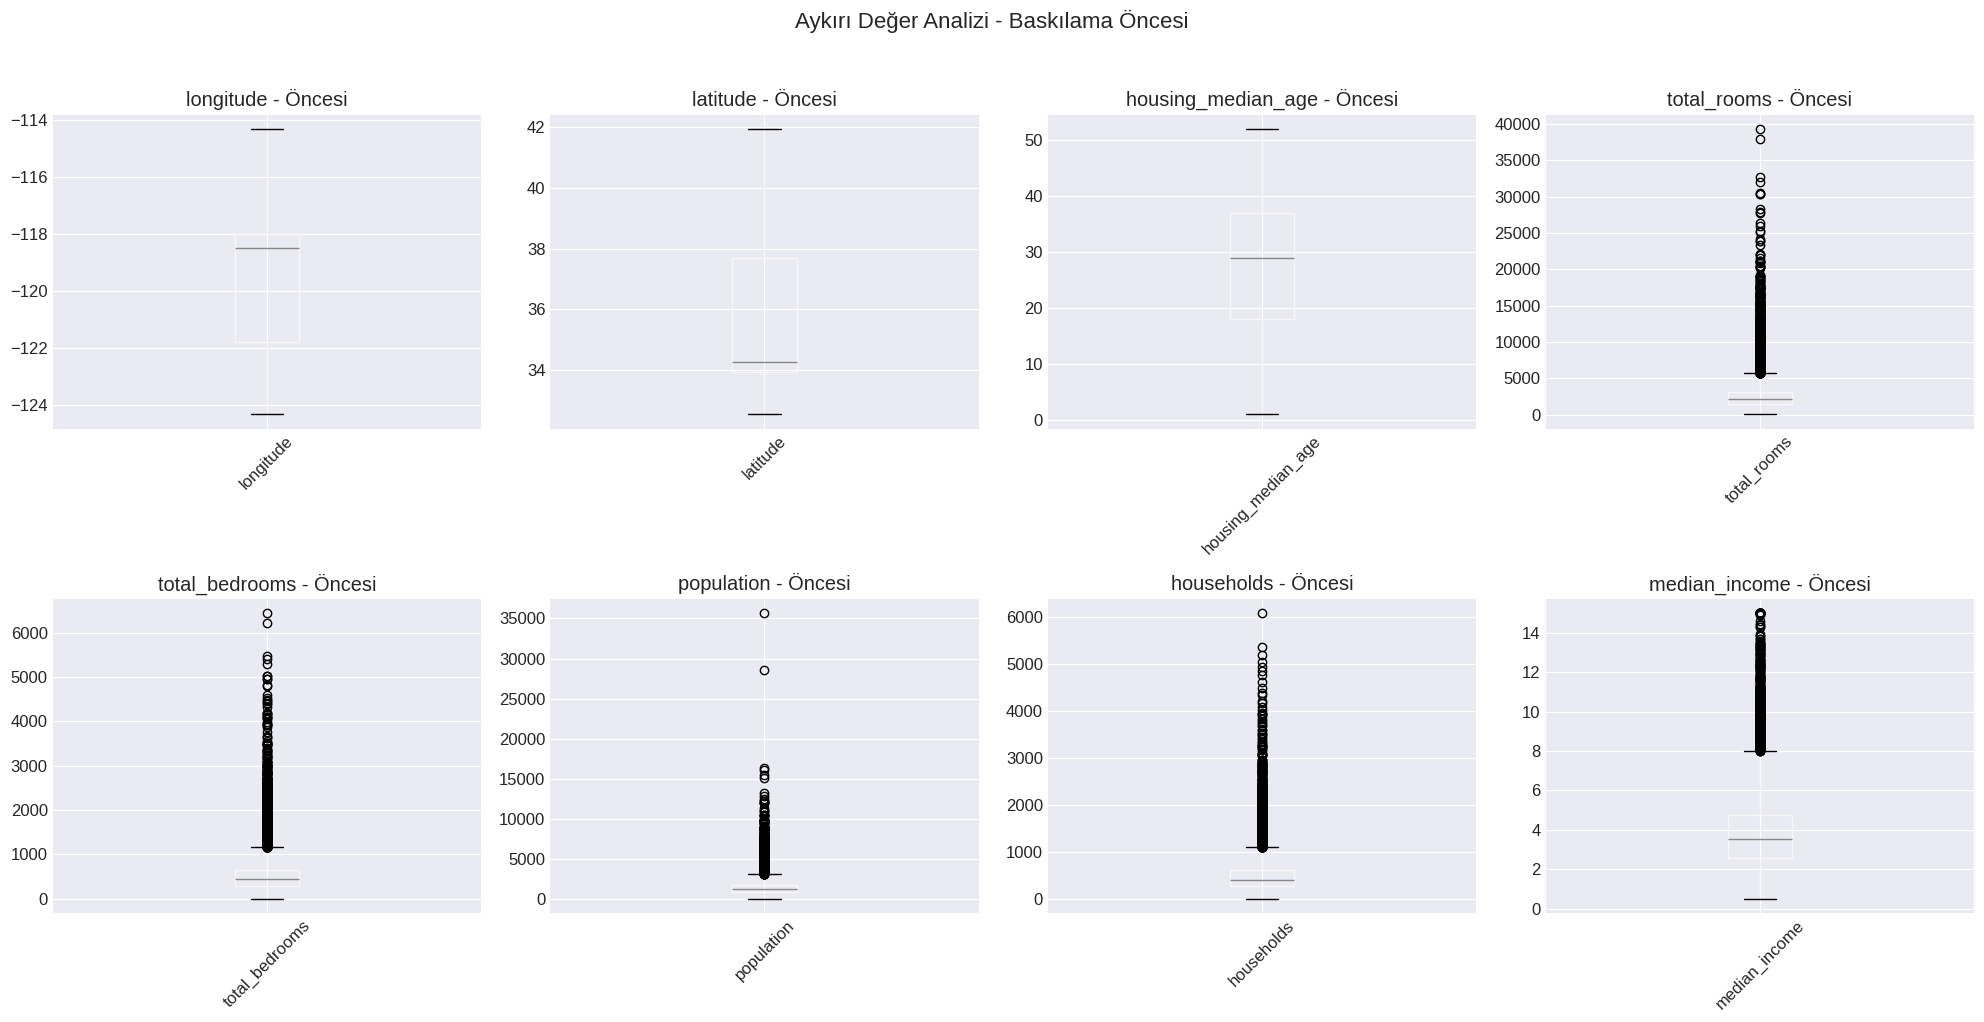

Aykırı değer baskılama işlemi:
longitude: Alt sınır=-127.48, Üst sınır=-112.33
latitude: Alt sınır=28.26, Üst sınır=43.38
housing_median_age: Alt sınır=-10.50, Üst sınır=65.50
total_rooms: Alt sınır=-1102.62, Üst sınır=5698.38
total_bedrooms: Alt sınır=-222.38, Üst sınır=1162.62
population: Alt sınır=-620.00, Üst sınır=3132.00
households: Alt sınır=-207.50, Üst sınır=1092.50
median_income: Alt sınır=-0.71, Üst sınır=8.01


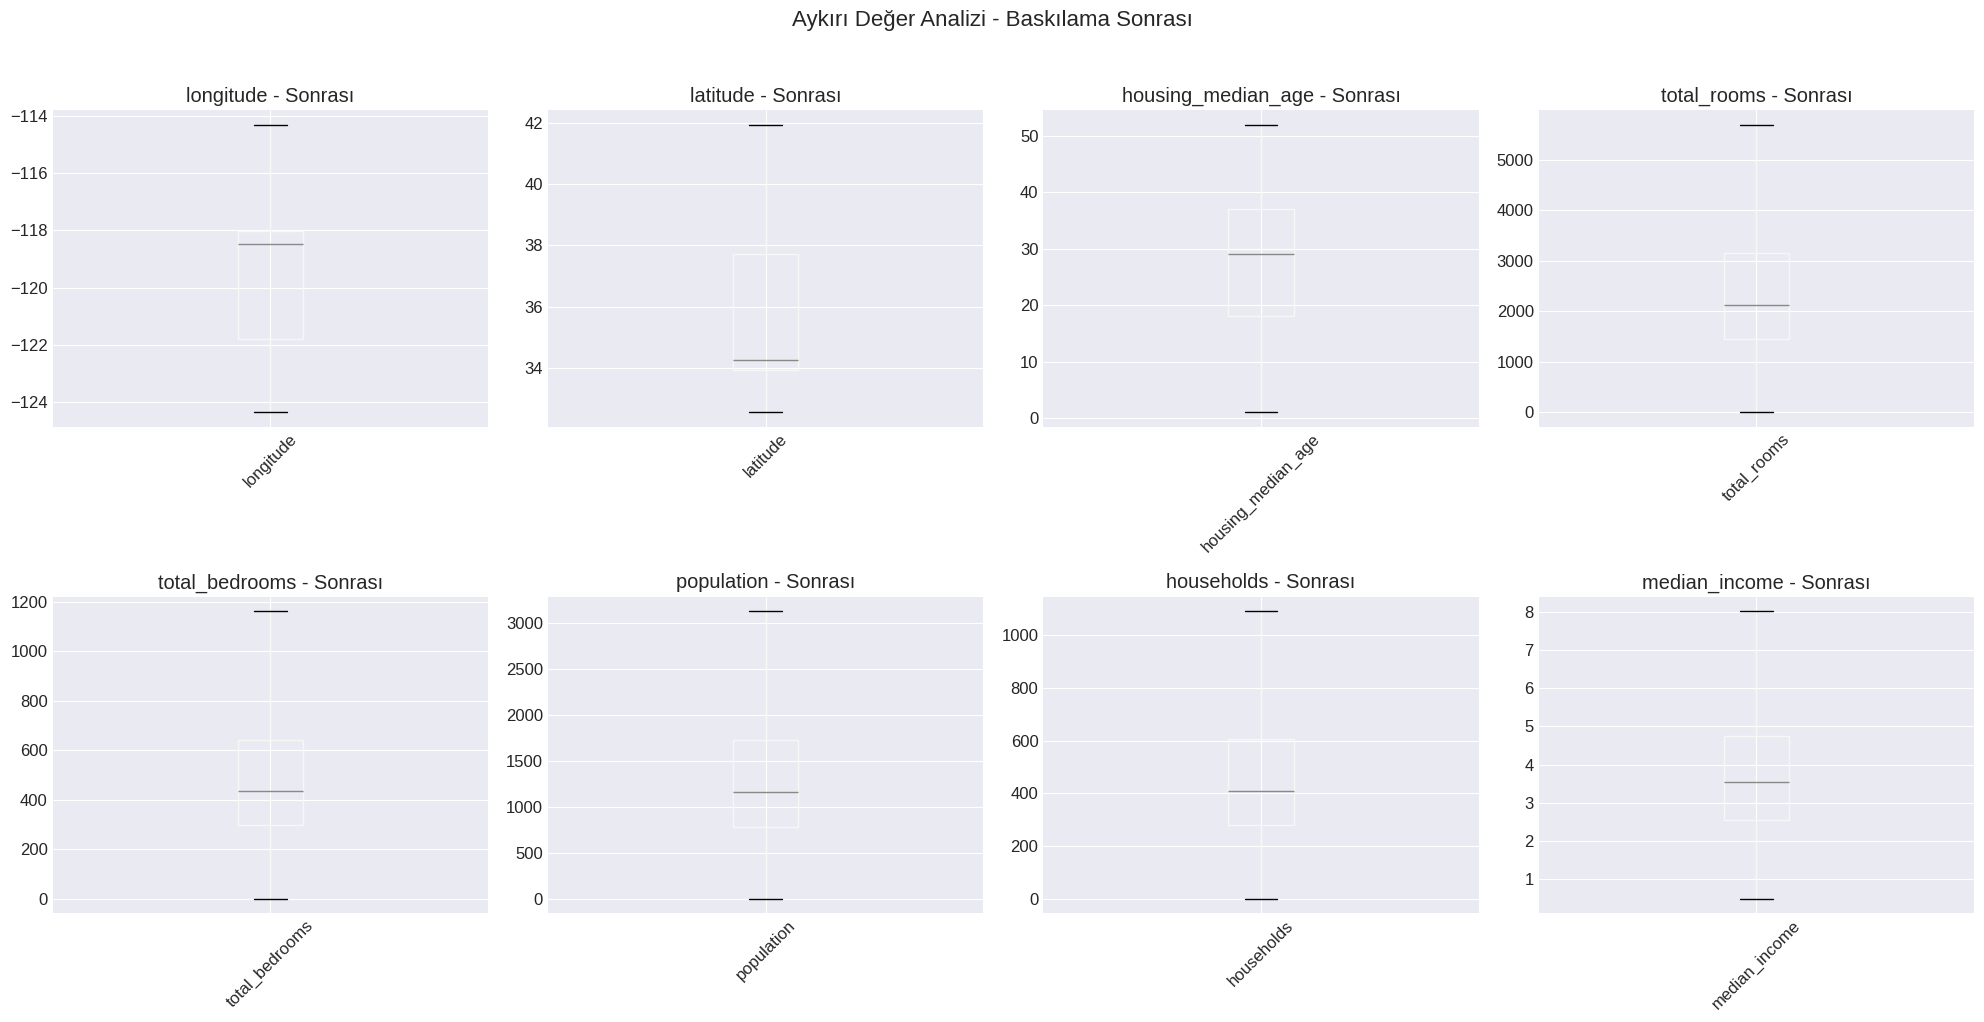

In [ ]:
# ==================== 6. AYKIRI DEĞER ANALİZİ VE BASKILAMA ====================

print("="*80)
print("AYKIRI DEĞER ANALİZİ (IQR YÖNTEMİ):")
print("="*80)

def detect_and_cap_outliers(df, column):
    """IQR yöntemi ile aykırı değerleri tespit et ve baskıla"""
    # [6.1] Çeyrek değerleri hesapla
    Q1 = df[column].quantile(0.25)  # 1. çeyrek (25. persentil)
    Q3 = df[column].quantile(0.75)  # 3. çeyrek (75. persentil)
    IQR = Q3 - Q1  # Çeyrekler arası aralık

    # [6.2] Alt ve üst sınırları hesapla
    lower_bound = Q1 - 1.5 * IQR  # Alt sınır
    upper_bound = Q3 + 1.5 * IQR  # Üst sınır

    # [6.3] Baskılama işlemi
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])  # Alt sınırdan küçükleri baskıla
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])  # Üst sınırdan büyükleri baskıla

    return df, lower_bound, upper_bound

# [6.4] Aykırı değer analizi için sayısal sütunlar
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
if 'median_house_value' in numeric_columns:
    numeric_columns.remove('median_house_value')  # Hedef değişkeni çıkar (baskılamıyoruz)

# [6.5] Aykırı değer işleme öncesi görselleştirme
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, col in enumerate(numeric_columns[:8]):
    df.boxplot(column=col, ax=axes[idx])  # Kutu grafiği oluştur
    axes[idx].set_title(f'{col} - Öncesi')
    axes[idx].tick_params(axis='x', rotation=45)

plt.suptitle('Aykırı Değer Analizi - Baskılama Öncesi', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('outliers_before.png', dpi=300, bbox_inches='tight')
plt.show()

# [6.6] Aykırı değerleri baskılama
print("Aykırı değer baskılama işlemi:")
for col in numeric_columns:
    df, lower, upper = detect_and_cap_outliers(df, col)
    print(f"{col}: Alt sınır={lower:.2f}, Üst sınır={upper:.2f}")

# [6.7] Aykırı değer işleme sonrası görselleştirme
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, col in enumerate(numeric_columns[:8]):
    df.boxplot(column=col, ax=axes[idx])
    axes[idx].set_title(f'{col} - Sonrası')
    axes[idx].tick_params(axis='x', rotation=45)

plt.suptitle('Aykırı Değer Analizi - Baskılama Sonrası', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('outliers_after.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n")

VERİ DÖNÜŞÜMÜ - LOGARİTMİK DÖNÜŞÜM:
Log dönüşümü uygulanacak çarpık değişkenler: ['total_rooms', 'total_bedrooms', 'population', 'households']


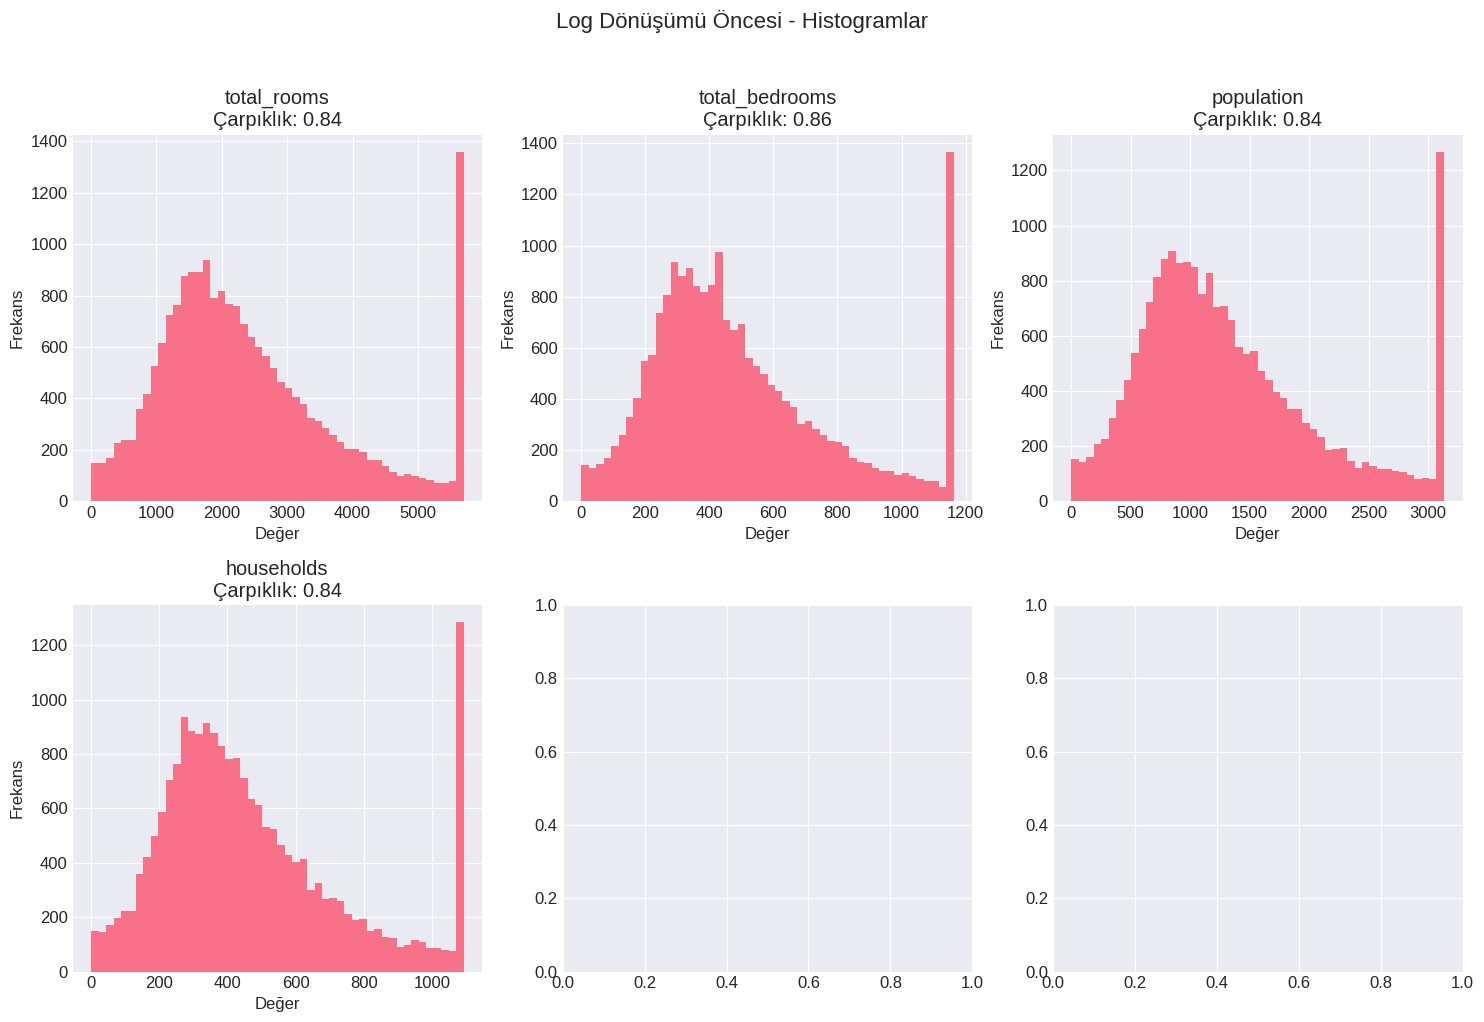

In [ ]:
# ==================== 7. VERİ DÖNÜŞÜMÜ (LOG DÖNÜŞÜMÜ) ====================

print("="*80)
print("VERİ DÖNÜŞÜMÜ - LOGARİTMİK DÖNÜŞÜM:")
print("="*80)

# [7.1] Çarpıklık (skewness) analizi
skewness_before = df[numeric_columns].skew()  # Her sütunun çarpıklık değeri
highly_skewed = skewness_before[abs(skewness_before) > 0.75].index.tolist()  # Çarpıklığı yüksek olanlar

print(f"Log dönüşümü uygulanacak çarpık değişkenler: {highly_skewed}")

# [7.2] Log dönüşümü öncesi histogramlar
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(highly_skewed[:6]):
    df[col].hist(bins=50, ax=axes[idx])  # Histogram çiz
    axes[idx].set_title(f'{col}\nÇarpıklık: {skewness_before[col]:.2f}')
    axes[idx].set_xlabel('Değer')
    axes[idx].set_ylabel('Frekans')

plt.suptitle('Log Dönüşümü Öncesi - Histogramlar', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('histograms_before_log.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# [7.3] Log dönüşümü uygulama
for col in highly_skewed:
    # [7.4] Negatif değerleri önlemek için log1p kullan (log(1+x))
    df[f'log_{col}'] = np.log1p(df[col])  # log1p = log(1 + x)
    df = df.drop(columns=[col])  # Orijinal sütunu sil

print("Log dönüşümü uygulandı.")
print(f"Yeni sütunlar: {[col for col in df.columns if 'log_' in col]}")

Log dönüşümü uygulandı.
Yeni sütunlar: ['log_total_rooms', 'log_total_bedrooms', 'log_population', 'log_households']


In [ ]:
# [7.5] Log dönüşümü sonrası çarpıklık
skewness_after = df[[col for col in df.columns if 'log_' in col]].skew()
print(f"\nÇarpıklık değerleri (Sonrası):")
for col in skewness_after.index:
    print(f"{col}: {skewness_after[col]:.2f}")



Çarpıklık değerleri (Sonrası):
log_total_rooms: -1.57
log_total_bedrooms: -1.46
log_population: -1.46
log_households: -1.47


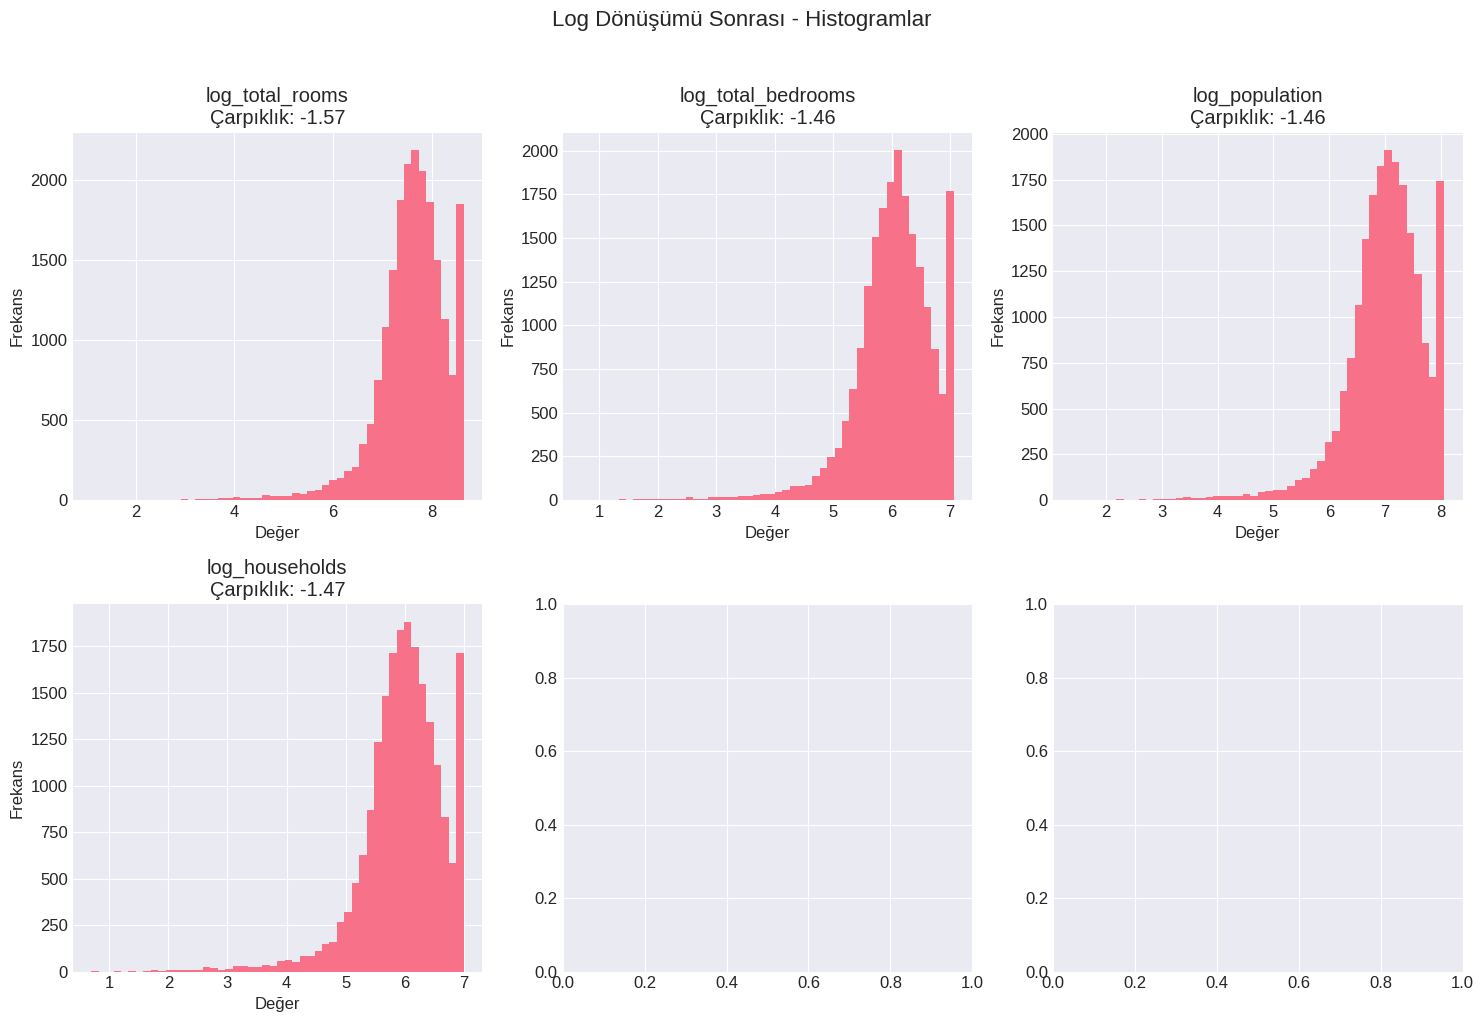

In [ ]:
# [7.6] Log dönüşümü sonrası histogramlar
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate([c for c in df.columns if 'log_' in c][:6]):
    df[col].hist(bins=50, ax=axes[idx])
    axes[idx].set_title(f'{col}\nÇarpıklık: {skewness_after[col]:.2f}')
    axes[idx].set_xlabel('Değer')
    axes[idx].set_ylabel('Frekans')

plt.suptitle('Log Dönüşümü Sonrası - Histogramlar', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('histograms_after_log.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n")


8. KEŞİFÇİ VERİ ANALİZİ (EDA)

KEŞİFÇİ VERİ ANALİZİ (EDA):
1. KORELASYON MATRİSİ ANALİZİ


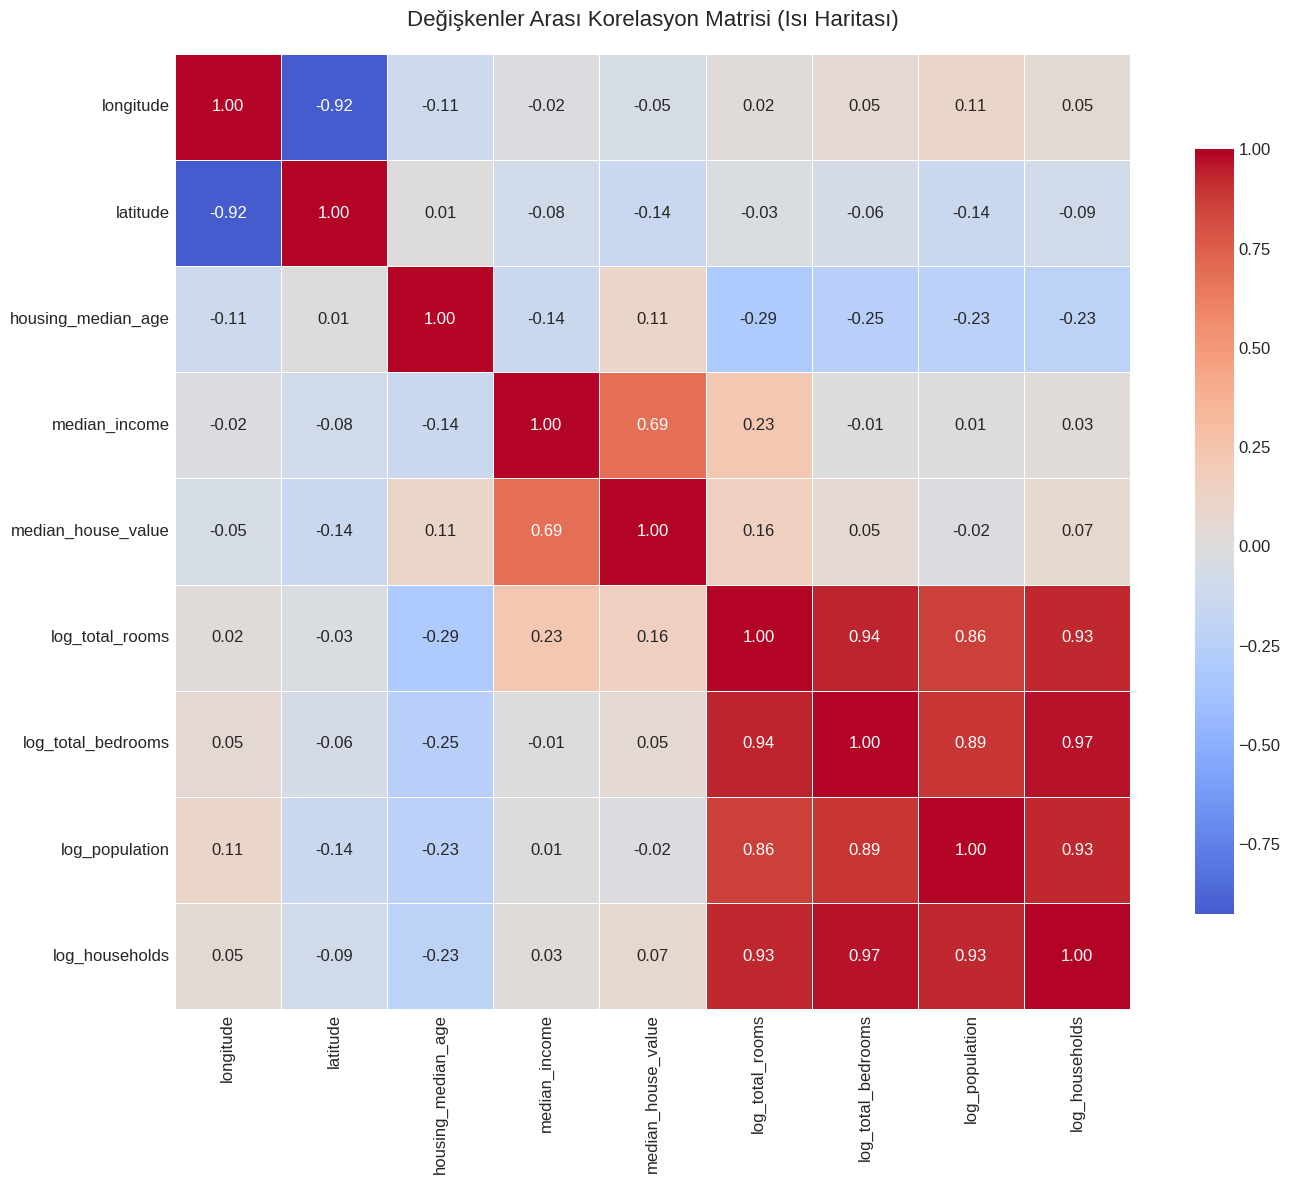

In [ ]:
# ==================== 8. KEŞİFÇİ VERİ ANALİZİ (EDA) ====================

print("="*80)
print("KEŞİFÇİ VERİ ANALİZİ (EDA):")
print("="*80)

# [8.1] Korelasyon Matrisi
print("1. KORELASYON MATRİSİ ANALİZİ")

# Korelasyon matrisi
correlation_matrix = df.select_dtypes(include=[np.number]).corr()  # Tüm sayısal sütunların korelasyonu

plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Değişkenler Arası Korelasyon Matrisi (Isı Haritası)', fontsize=16, pad=20)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# [8.2] Hedef değişkenle en yüksek korelasyona sahip 5 değişken
top_correlations = correlation_matrix['median_house_value'].abs().sort_values(ascending=False)[1:6]
print(f"\nHedef değişkenle en yüksek korelasyona sahip 5 değişken:")
for idx, (feature, corr) in enumerate(top_correlations.items(), 1):
    print(f"{idx}. {feature}: {corr:.3f}")


Hedef değişkenle en yüksek korelasyona sahip 5 değişken:
1. median_income: 0.689
2. log_total_rooms: 0.161
3. latitude: 0.144
4. housing_median_age: 0.106
5. log_households: 0.074



2. DAĞILIM GRAFİKLERİ


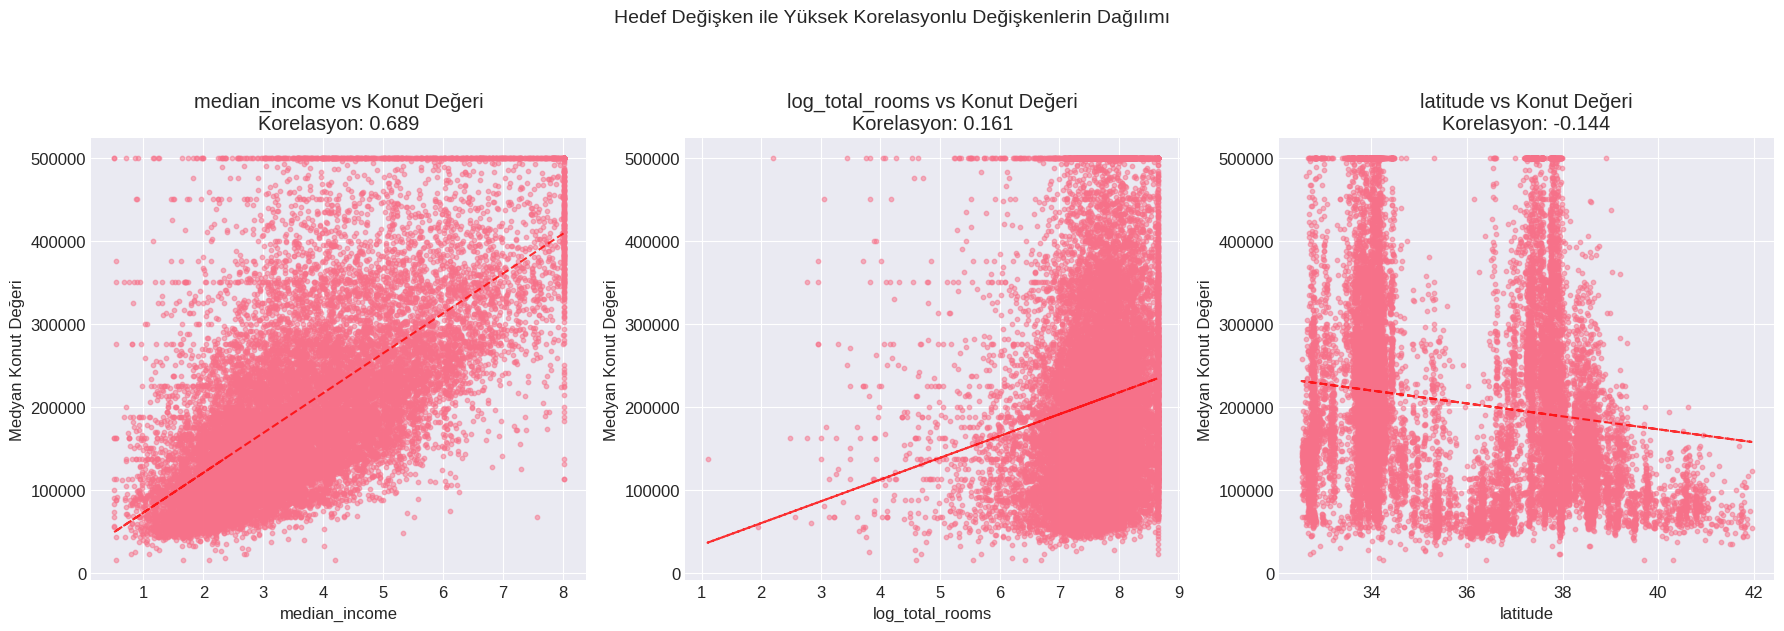

In [ ]:
# [8.3] Dağılım Grafikleri (Scatter Plots)
print("\n2. DAĞILIM GRAFİKLERİ")

# En yüksek korelasyonlu 3 değişken için scatter plot
top_3_features = top_correlations.index[:3]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for idx, feature in enumerate(top_3_features):
    # [8.4] Saçılım grafiği oluştur
    axes[idx].scatter(df[feature], df['median_house_value'], alpha=0.5, s=10)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Medyan Konut Değeri')
    axes[idx].set_title(f'{feature} vs Konut Değeri\nKorelasyon: {correlation_matrix.loc[feature, "median_house_value"]:.3f}')
# [8.5] Trend çizgisi ekleme (lineer regresyon)
    z = np.polyfit(df[feature], df['median_house_value'], 1)  # 1. derece polinom fit
    p = np.poly1d(z)  # Polinom fonksiyonu oluştur
    axes[idx].plot(df[feature], p(df[feature]), "r--", alpha=0.8)  # Trend çizgisini çiz

plt.suptitle('Hedef Değişken ile Yüksek Korelasyonlu Değişkenlerin Dağılımı', fontsize=14, y=1.05)
plt.tight_layout()
plt.savefig('scatter_plots.png', dpi=300, bbox_inches='tight')
plt.show()


3. KATEGORİK DEĞİŞKEN ANALİZİ


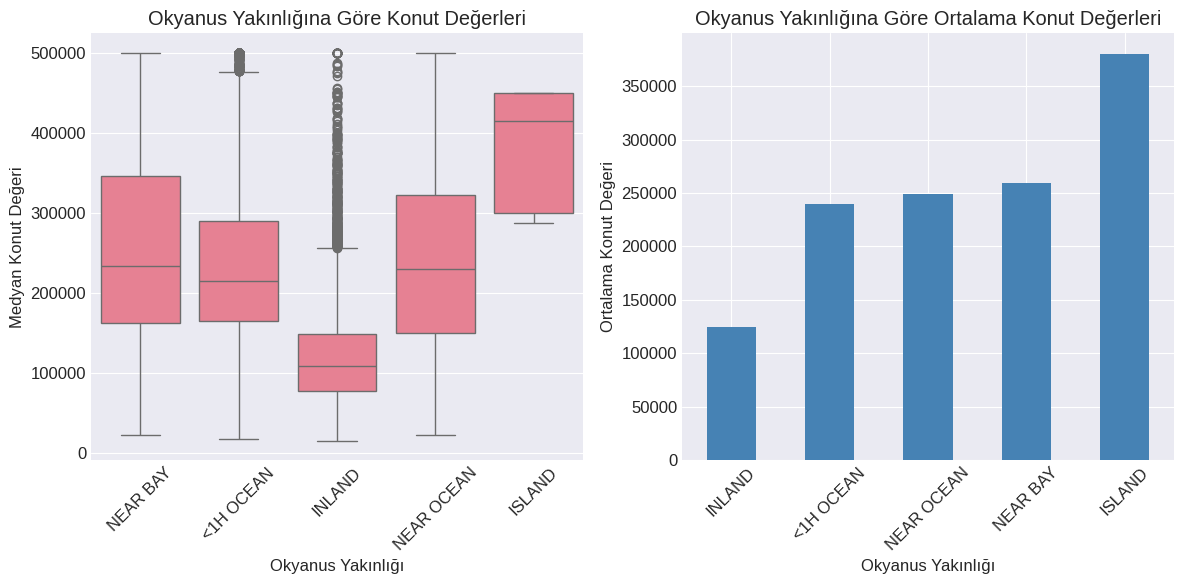


Okyanus yakınlığı kategorileri: ['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND']

Ortalama konut değerleri:
ocean_proximity
INLAND        124805.39
<1H OCEAN     240084.29
NEAR OCEAN    249433.98
NEAR BAY      259212.31
ISLAND        380440.00
Name: median_house_value, dtype: float64




In [ ]:
# [8.6] Kategorik Değişken Analizi
print("\n3. KATEGORİK DEĞİŞKEN ANALİZİ")

if 'ocean_proximity' in df.columns:
    plt.figure(figsize=(12, 6))

    # [8.7] Kutu grafiği (boxplot)
    plt.subplot(1, 2, 1)
    sns.boxplot(x='ocean_proximity', y='median_house_value', data=df)
    plt.title('Okyanus Yakınlığına Göre Konut Değerleri')
    plt.xlabel('Okyanus Yakınlığı')
    plt.ylabel('Medyan Konut Değeri')
    plt.xticks(rotation=45)
# [8.8] Bar plot (ortalama değerler)
    plt.subplot(1, 2, 2)
    mean_values = df.groupby('ocean_proximity')['median_house_value'].mean().sort_values()
    mean_values.plot(kind='bar', color='steelblue')
    plt.title('Okyanus Yakınlığına Göre Ortalama Konut Değerleri')
    plt.xlabel('Okyanus Yakınlığı')
    plt.ylabel('Ortalama Konut Değeri')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.savefig('categorical_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\nOkyanus yakınlığı kategorileri: {df['ocean_proximity'].unique().tolist()}")
    print("\nOrtalama konut değerleri:")
    print(mean_values.round(2))

print("\n")

9. ÖZELLİK MÜHENDİSLİĞİ

In [ ]:
# ==================== 9. ÖZELLİK MÜHENDİSLİĞİ ====================

print("="*80)
print("ÖZELLİK MÜHENDİSLİĞİ:")
print("="*80)

# [9.1] Yeni özellikler oluşturma
print("1. YENİ ÖZELLİKLER OLUŞTURMA")

# Orijinal değişkenleri korumak için kopya oluştur
df_features = df.copy()

# [9.2] Coğrafi özellikler ekleme
print("Coğrafi özellikler ekleniyor...")
# Büyük şehir merkezlerine uzaklık (yaklaşık koordinatlar)
LA_COORDS = (34.05, -118.24)  # Los Angeles koordinatları
SF_COORDS = (37.77, -122.42)  # San Francisco koordinatları
SD_COORDS = (32.72, -117.16)  # San Diego koordinatları

def calculate_distance(lat1, lon1, lat2, lon2):
    """İki koordinat arasındaki yaklaşık Öklid mesafesini hesapla"""
    return np.sqrt((lat1 - lat2)**2 + (lon1 - lon2)**2)

# [9.3] Her şehre olan mesafeyi hesapla
df_features['distance_to_LA'] = calculate_distance(df_features['latitude'],
                                                    df_features['longitude'],
                                                    LA_COORDS[0], LA_COORDS[1])
df_features['distance_to_SF'] = calculate_distance(df_features['latitude'],
                                                    df_features['longitude'],
                                                    SF_COORDS[0], SF_COORDS[1])
df_features['distance_to_SD'] = calculate_distance(df_features['latitude'],
                                                    df_features['longitude'],
                                                    SD_COORDS[0], SD_COORDS[1])

# [9.4] Ortalama mesafe
df_features['avg_distance_to_cities'] = df_features[['distance_to_LA',
                                                      'distance_to_SF',
                                                      'distance_to_SD']].mean(axis=1)

# [9.5] Demografik özellikler ekleme
print("Demografik özellikler ekleniyor...")
if 'log_total_rooms' in df_features.columns and 'households' in df_features.columns:
    df_features['rooms_per_household'] = df_features['log_total_rooms'] / (df_features['households'] + 1)

if 'log_total_bedrooms' in df_features.columns and 'log_total_rooms' in df_features.columns:
    df_features['bedrooms_per_room'] = df_features['log_total_bedrooms'] / (df_features['log_total_rooms'] + 1)

if 'log_population' in df_features.columns and 'households' in df_features.columns:
    df_features['population_per_household'] = df_features['log_population'] / (df_features['households'] + 1)

print(f"Toplam özellik sayısı: {len(df_features.columns)}")
print(f"Yeni özellikler: {[col for col in df_features.columns if col not in df.columns]}")


ÖZELLİK MÜHENDİSLİĞİ:
1. YENİ ÖZELLİKLER OLUŞTURMA
Coğrafi özellikler ekleniyor...
Demografik özellikler ekleniyor...
Toplam özellik sayısı: 15
Yeni özellikler: ['distance_to_LA', 'distance_to_SF', 'distance_to_SD', 'avg_distance_to_cities', 'bedrooms_per_room']


In [ ]:
# [9.6] One-Hot Encoding
print("\n2. ONE-HOT ENCODING")

if 'ocean_proximity' in df_features.columns:
    # One-hot encoding uygula
    ocean_proximity_dummies = pd.get_dummies(df_features['ocean_proximity'],
                                              prefix='ocean',
                                              drop_first=True)  # İlk kategorik değeri referans olarak bırak

    # Orijinal sütunu sil ve encoded sütunları ekle
    df_features = df_features.drop(columns=['ocean_proximity'])
    df_features = pd.concat([df_features, ocean_proximity_dummies], axis=1)

    print(f"One-hot encoding uygulandı. Yeni sütunlar: {ocean_proximity_dummies.columns.tolist()}")


2. ONE-HOT ENCODING


In [ ]:
# [9.7] Veri Standardizasyonu
print("\n3. VERİ STANDARDİZASYONU")

# Hedef değişkeni ayır
target = 'median_house_value'
if target in df_features.columns:
    y = df_features[target]  # Hedef değişken
    X = df_features.drop(columns=[target])  # Bağımsız değişkenler
else:
    print("Hedef değişken bulunamadı!")
    y = None
    X = df_features

# [9.8] StandardScaler uygula (ortalama=0, standart sapma=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Standardizasyon uygula
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)  # DataFrame'e dönüştür

print(f"Standardizasyon uygulandı. Özellik sayısı: {X_scaled.shape[1]}")

# [9.9] Özellik Seçimi (RFE)
print("\n4. GERİYE DÖNÜK ÖZELLİK ELEME (RFE)")

# RFE için baseline model (Linear Regression)
from sklearn.linear_model import LinearRegression

# Örnek olarak en iyi 15 özelliği seç
rfe_selector = RFE(
    estimator=LinearRegression(),  # Temel model
    n_features_to_select=15,       # Seçilecek özellik sayısı
    step=1,                        # Her adımda çıkarılacak özellik sayısı
    verbose=0                      # Günlük çıktıyı kapat
)

rfe_selector.fit(X_scaled, y)  # RFE'yi eğit

# [9.10] Seçilen özellikler
selected_features = X_scaled.columns[rfe_selector.support_].tolist()
print(f"RFE ile seçilen {len(selected_features)} özellik:")
for i, feature in enumerate(selected_features, 1):
    print(f"{i}. {feature}")

# [9.11] RFE ranking (özelliklerin önem sıralaması)
feature_ranking = pd.DataFrame({
    'Özellik': X_scaled.columns,
    'RFE Ranking': rfe_selector.ranking_,  # 1 en önemli
    'Seçildi': rfe_selector.support_       # True/False
}).sort_values('RFE Ranking')

print("\nRFE Sıralaması (ilk 20):")
print(feature_ranking.head(20).to_string(index=False))

# [9.12] Seçilen özelliklerle yeni veri seti oluştur
X_selected = X_scaled[selected_features]

print(f"\nSeçilen özelliklerle yeni veri seti boyutu: {X_selected.shape}")

print("\n")



3. VERİ STANDARDİZASYONU
Standardizasyon uygulandı. Özellik sayısı: 17

4. GERİYE DÖNÜK ÖZELLİK ELEME (RFE)
RFE ile seçilen 15 özellik:
1. longitude
2. latitude
3. housing_median_age
4. median_income
5. log_total_rooms
6. log_total_bedrooms
7. log_population
8. log_households
9. distance_to_LA
10. distance_to_SF
11. distance_to_SD
12. avg_distance_to_cities
13. bedrooms_per_room
14. ocean_INLAND
15. ocean_NEAR OCEAN

RFE Sıralaması (ilk 20):
               Özellik  RFE Ranking  Seçildi
             longitude            1     True
              latitude            1     True
    housing_median_age            1     True
         median_income            1     True
       log_total_rooms            1     True
    log_total_bedrooms            1     True
        log_population            1     True
        log_households            1     True
        distance_to_LA            1     True
        distance_to_SF            1     True
        distance_to_SD            1     True
avg_distance_

10. VERİ SETİNİ BÖLME

In [ ]:
# ==================== 10. VERİ SETİNİ BÖLME ====================

print("="*80)
print("VERİ SETİ BÖLME İŞLEMİ:")
print("="*80)

# [10.1] Veriyi eğitim ve test olarak bölme (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y,
    test_size=0.2,       # Test seti oranı
    random_state=42      # Reprodüksiyon için random seed
)

print(f"Eğitim seti boyutu: {X_train.shape}")
print(f"Test seti boyutu: {X_test.shape}")
print(f"Eğitim seti oranı: {len(X_train) / len(X_selected) * 100:.1f}%")
print(f"Test seti oranı: {len(X_test) / len(X_selected) * 100:.1f}%")

print("\n")

VERİ SETİ BÖLME İŞLEMİ:
Eğitim seti boyutu: (16512, 15)
Test seti boyutu: (4128, 15)
Eğitim seti oranı: 80.0%
Test seti oranı: 20.0%




11. MODEL KURMA VE DEĞERLENDİRME

In [ ]:
# ==================== 11. MODEL KURMA VE DEĞERLENDİRME ====================

print("="*80)
print("MODEL KURMA VE DEĞERLENDİRME:")
print("="*80)

# [11.1] Modelleri tanımla
print("1. MODELLERİN TANIMLANMASI")

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=42),
    'Lasso Regression': Lasso(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1),  # n_jobs=-1: tüm CPU çekirdeklerini kullan
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor(),
    'XGBoost': XGBRegressor(random_state=42, verbosity=0)  # verbosity=0: günlük çıktıyı kapat
}

# [11.2] GridSearchCV için parametre grid'leri
print("\n2. HİPERPARAMETRE OPTİMİZASYONU (GRIDSEARCHCV)")

param_grids = {
    'Ridge Regression': {
        'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],  # Regularizasyon gücü
        'solver': ['auto', 'svd', 'cholesky', 'lsqr']  # Çözüm algoritması
    },
    'Lasso Regression': {
        'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],  # Regularizasyon gücü
        'max_iter': [1000, 5000]  # Maksimum iterasyon sayısı
    },
    'Decision Tree': {
        'max_depth': [None, 10, 20, 30],  # Maksimum derinlik
        'min_samples_split': [2, 5, 10],  # Bölme için minimum örnek sayısı
        'min_samples_leaf': [1, 2, 4]     # Yaprak için minimum örnek sayısı
    },
    'Random Forest': {
        'n_estimators': [100, 200],       # Ağaç sayısı
        'max_depth': [None, 10, 20],      # Maksimum derinlik
        'min_samples_split': [2, 5]       # Bölme için minimum örnek sayısı
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],       # Tahminci sayısı
        'learning_rate': [0.01, 0.1],     # Öğrenme oranı
        'max_depth': [3, 4, 5]            # Maksimum derinlik
    },
    'SVR': {
        'C': [0.1, 1.0, 10.0],            # Regularizasyon parametresi
        'kernel': ['linear', 'rbf'],      # Çekirdek fonksiyonu
        'epsilon': [0.01, 0.1, 0.2]       # Epsilon-tube genişliği
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9],      # Komşu sayısı
        'weights': ['uniform', 'distance'], # Ağırlıklandırma
        'metric': ['euclidean', 'manhattan'] # Uzaklık metriği
    },
    'XGBoost': {
        'n_estimators': [100, 200],       # Ağaç sayısı
        'learning_rate': [0.01, 0.1],     # Öğrenme oranı
        'max_depth': [3, 5, 7]            # Maksimum derinlik
    }
}

# [11.3] Model eğitimi ve değerlendirme
print("\n3. MODEL EĞİTİMİ VE DEĞERLENDİRMESİ")

results = {}      # Model sonuçlarını saklamak için
best_models = {}  # En iyi modelleri saklamak için

for model_name in models.keys():
    print(f"\n{model_name} modeli eğitiliyor...")
    print("-" * 50)

    # Model seç
    model = models[model_name]

    # [11.4] GridSearchCV uygula (eğer parametre grid'i varsa)
    if model_name in param_grids:
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grids[model_name],
            cv=5,                          # 5-katlı çapraz doğrulama
            scoring='neg_mean_squared_error', # Skorlama metriği
            n_jobs=-1,                     # Tüm CPU çekirdeklerini kullan
            verbose=0                      # Günlük çıktıyı kapat
        )

        grid_search.fit(X_train, y_train)  # GridSearch ile eğit

        # En iyi modeli kaydet
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

        print(f"En iyi parametreler: {best_params}")
        print(f"En iyi skor (neg MSE): {grid_search.best_score_:.4f}")
    else:
        # GridSearchCV olmadan direkt eğit (ör. Linear Regression)
        best_model = model
        best_model.fit(X_train, y_train)

    # Modeli kaydet
    best_models[model_name] = best_model

    # [11.5] Çapraz doğrulama skorları
    cv_scores = cross_val_score(
        best_model, X_train, y_train,
        cv=KFold(n_splits=5, shuffle=True, random_state=42),  # 5-katlı CV
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    cv_rmse = np.sqrt(-cv_scores)  # RMSE'ye çevir (negatif MSE'den)
    cv_r2 = cross_val_score(
        best_model, X_train, y_train,
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        scoring='r2',  # R² skoru
        n_jobs=-1
    )

    # [11.6] Test seti tahminleri
    y_pred = best_model.predict(X_test)

    # [11.7] Metrikleri hesapla
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)  # Kök ortalama kare hata
    mae = mean_absolute_error(y_test, y_pred)  # Ortalama mutlak hata
    r2 = r2_score(y_test, y_pred)  # R² skoru

    # [11.8] MAPE hesapla (yüzde hata)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    # Sonuçları kaydet
    results[model_name] = {
        'CV_RMSE_mean': cv_rmse.mean(),    # CV RMSE ortalaması
        'CV_RMSE_std': cv_rmse.std(),      # CV RMSE standart sapması
        'CV_R2_mean': cv_r2.mean(),        # CV R² ortalaması
        'CV_R2_std': cv_r2.std(),          # CV R² standart sapması
        'Test_RMSE': rmse,                 # Test RMSE
        'Test_MAE': mae,                   # Test MAE
        'Test_MAPE': mape,                 # Test MAPE
        'Test_R2': r2,                     # Test R²
        'Training_Time': None              # Zaman ölçümü eklenebilir
    }

    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R²: {r2:.4f}")
    print(f"Test MAPE: {mape:.2f}%")
    print(f"CV RMSE (ortalama ± std): {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")
    print(f"CV R² (ortalama ± std): {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")

print("\n")

# [11.9] Stacking Modeli
print("\n4. STACKING MODELİ (ENSEMBLE)")

# En iyi 3 modeli seç (R² skoruna göre)
top_models = sorted(results.items(), key=lambda x: x[1]['Test_R2'], reverse=True)[:3]
top_model_names = [model[0] for model in top_models]

print(f"En iyi 3 model Stacking için seçildi: {top_model_names}")

# [11.10] Stacking modeli oluştur
base_models = [(name, best_models[name]) for name in top_model_names]
stacking_model = StackingRegressor(
    estimators=base_models,                 # Temel modeller
    final_estimator=LinearRegression(),     # Meta-öğrenici
    cv=5,                                   # Çapraz doğrulama katları
    n_jobs=-1                               # Paralel işleme
)


MODEL KURMA VE DEĞERLENDİRME:
1. MODELLERİN TANIMLANMASI

2. HİPERPARAMETRE OPTİMİZASYONU (GRIDSEARCHCV)

3. MODEL EĞİTİMİ VE DEĞERLENDİRMESİ

Linear Regression modeli eğitiliyor...
--------------------------------------------------
Test RMSE: 68731.4177
Test MAE: 49922.3334
Test R²: 0.6395
Test MAPE: 29.63%
CV RMSE (ortalama ± std): 65106.0258 ± 1494.4693
CV R² (ortalama ± std): 0.6827 ± 0.0116

Ridge Regression modeli eğitiliyor...
--------------------------------------------------
En iyi parametreler: {'alpha': 0.1, 'solver': 'auto'}
En iyi skor (neg MSE): -4243233375.3274
Test RMSE: 68730.5311
Test MAE: 49921.6668
Test R²: 0.6395
Test MAPE: 29.63%
CV RMSE (ortalama ± std): 65105.9992 ± 1494.5851
CV R² (ortalama ± std): 0.6827 ± 0.0116

Lasso Regression modeli eğitiliyor...
--------------------------------------------------
En iyi parametreler: {'alpha': 0.001, 'max_iter': 5000}
En iyi skor (neg MSE): -4243234618.0964
Test RMSE: 68731.4175
Test MAE: 49922.3329
Test R²: 0.6395
Test M

In [ ]:
# Stacking modelini eğit
stacking_model.fit(X_train, y_train)

# Stacking modelini değerlendir
y_pred_stack = stacking_model.predict(X_test)

stack_rmse = np.sqrt(mean_squared_error(y_test, y_pred_stack))
stack_mae = mean_absolute_error(y_test, y_pred_stack)
stack_r2 = r2_score(y_test, y_pred_stack)
stack_mape = np.mean(np.abs((y_test - y_pred_stack) / y_test)) * 100

# Stacking sonuçlarını kaydet
results['Stacking'] = {
    'CV_RMSE_mean': None,
    'CV_RMSE_std': None,
    'CV_R2_mean': None,
    'CV_R2_std': None,
    'Test_RMSE': stack_rmse,
    'Test_MAE': stack_mae,
    'Test_MAPE': stack_mape,
    'Test_R2': stack_r2,
    'Training_Time': None
}

print(f"Stacking Model Sonuçları:")
print(f"Test RMSE: {stack_rmse:.4f}")
print(f"Test MAE: {stack_mae:.4f}")
print(f"Test R²: {stack_r2:.4f}")
print(f"Test MAPE: {stack_mape:.2f}%")

print("\n")

Stacking Model Sonuçları:
Test RMSE: 45934.7838
Test MAE: 29743.9197
Test R²: 0.8390
Test MAPE: 16.60%




12. SONUÇLARIN KARŞILAŞTIRILMASI

MODEL PERFORMANS KARŞILAŞTIRMASI:
Tüm Modellerin Test Seti Performansı:
                  Test_R2   Test_RMSE    Test_MAE Test_MAPE
XGBoost            0.8374  46155.3690  29964.6845    16.85%
Gradient Boosting  0.8203  48528.2284  31942.7794    18.05%
Random Forest      0.8192  48668.3209  31161.4829    17.31%
KNN                0.7629  55735.0793  37013.3439    19.87%
Decision Tree      0.7374  58665.4443  39261.4214    21.74%
Ridge Regression   0.6395  68730.5311  49921.6668    29.63%
Lasso Regression   0.6395  68731.4175  49922.3329    29.63%
Linear Regression  0.6395  68731.4177  49922.3334    29.63%
SVR                0.5158  79651.5388  53767.9044    27.27%


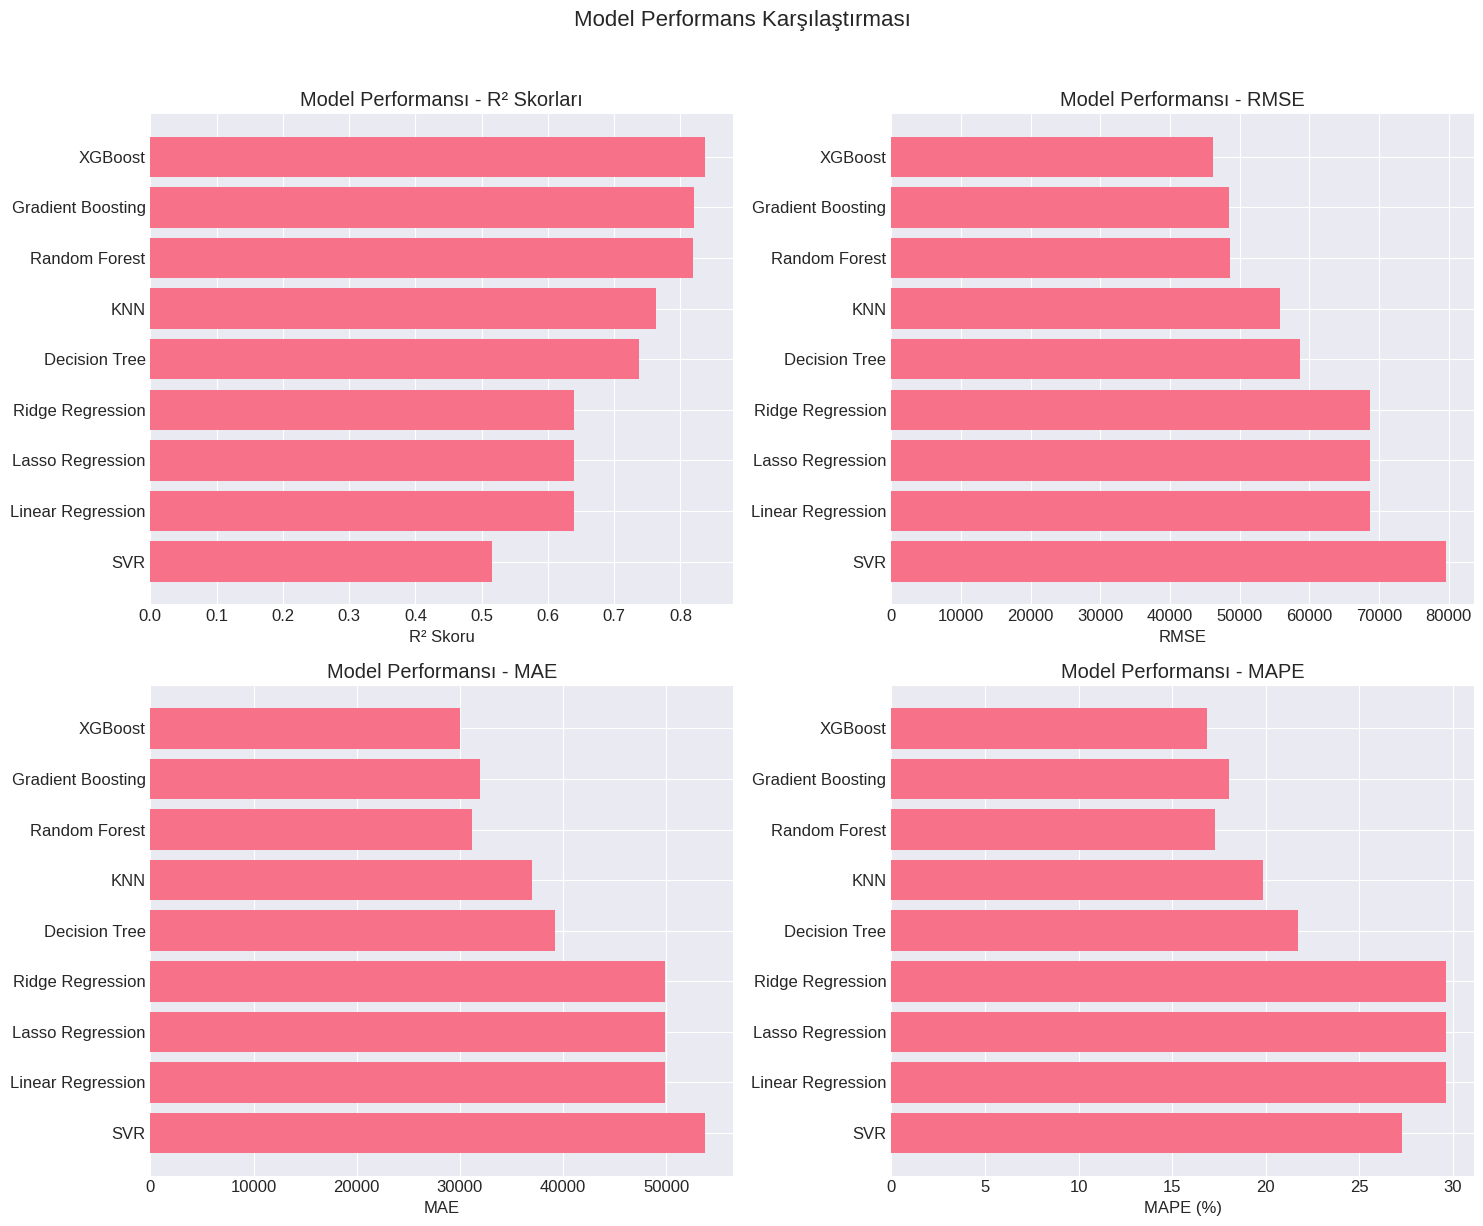

In [ ]:
# ==================== 12. SONUÇLARIN KARŞILAŞTIRILMASI ====================

print("="*80)
print("MODEL PERFORMANS KARŞILAŞTIRMASI:")
print("="*80)

# [12.1] Sonuçları DataFrame'e dönüştür
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('Test_R2', ascending=False)  # R²'ye göre sırala

# [12.2] Metrikleri formatla
for col in ['Test_RMSE', 'Test_MAE', 'Test_MAPE', 'Test_R2']:
    if col == 'Test_R2':
        results_df[col] = results_df[col].map(lambda x: f'{x:.4f}')  # 4 ondalık
    elif col == 'Test_MAPE':
        results_df[col] = results_df[col].map(lambda x: f'{x:.2f}%')  # Yüzde formatı
    else:
        results_df[col] = results_df[col].map(lambda x: f'{x:.4f}')

print("Tüm Modellerin Test Seti Performansı:")
print("="*80)
print(results_df[['Test_R2', 'Test_RMSE', 'Test_MAE', 'Test_MAPE']].to_string())

# [12.3] Performans karşılaştırma grafiği
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# R² skorları
axes[0, 0].barh(range(len(results_df)), results_df['Test_R2'].astype(float))
axes[0, 0].set_yticks(range(len(results_df)))
axes[0, 0].set_yticklabels(results_df.index)
axes[0, 0].set_xlabel('R² Skoru')
axes[0, 0].set_title('Model Performansı - R² Skorları')
axes[0, 0].invert_yaxis()  # En iyi model üstte

# RMSE değerleri
axes[0, 1].barh(range(len(results_df)), results_df['Test_RMSE'].astype(float))
axes[0, 1].set_yticks(range(len(results_df)))
axes[0, 1].set_yticklabels(results_df.index)
axes[0, 1].set_xlabel('RMSE')
axes[0, 1].set_title('Model Performansı - RMSE')
axes[0, 1].invert_yaxis()

# MAE değerleri
axes[1, 0].barh(range(len(results_df)), results_df['Test_MAE'].astype(float))
axes[1, 0].set_yticks(range(len(results_df)))
axes[1, 0].set_yticklabels(results_df.index)
axes[1, 0].set_xlabel('MAE')
axes[1, 0].set_title('Model Performansı - MAE')
axes[1, 0].invert_yaxis()

# MAPE değerleri
axes[1, 1].barh(range(len(results_df)), results_df['Test_MAPE'].astype(str).str.replace('%', '').astype(float))
axes[1, 1].set_yticks(range(len(results_df)))
axes[1, 1].set_yticklabels(results_df.index)
axes[1, 1].set_xlabel('MAPE (%)')
axes[1, 1].set_title('Model Performansı - MAPE')
axes[1, 1].invert_yaxis()

plt.suptitle('Model Performans Karşılaştırması', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n")

13. EN İYİ MODEL ANALİZİ

EN İYİ MODEL ANALİZİ:
En iyi performans gösteren model: Stacking
Test R²: 0.8390
Test RMSE: 45934.7838
Test MAE: 29743.9197
Test MAPE: 16.60%


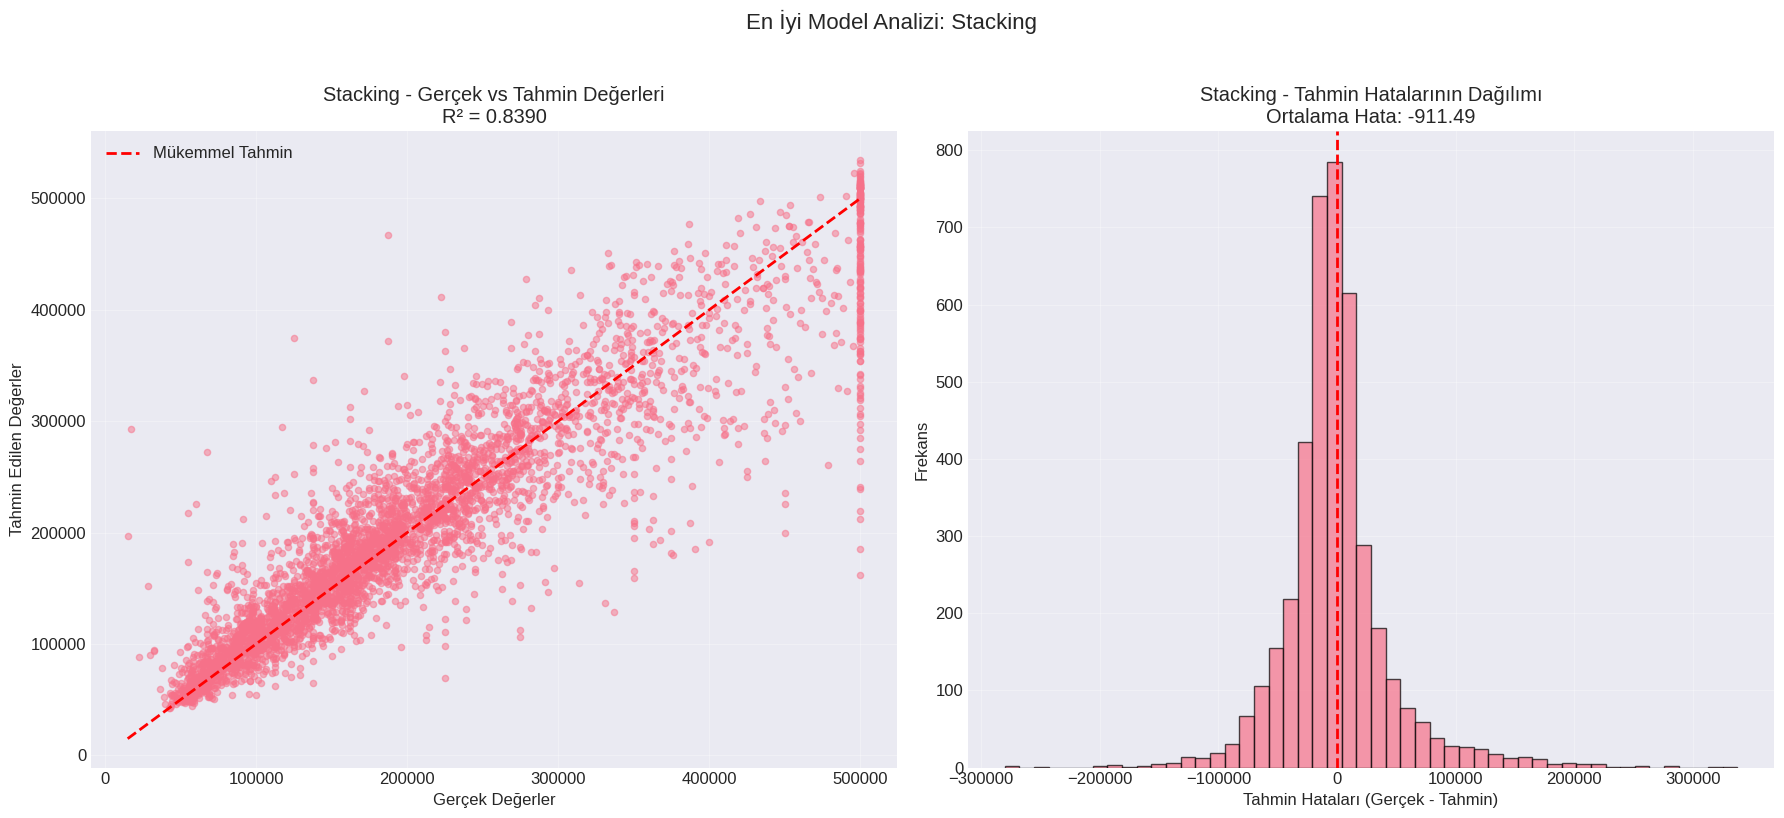

In [ ]:
# ==================== 13. EN İYİ MODEL ANALİZİ ====================

print("="*80)
print("EN İYİ MODEL ANALİZİ:")
print("="*80)

# [13.1] En iyi modeli belirle (ilk sıradaki)
best_model_name = results_df.index[0]
best_model = best_models.get(best_model_name, stacking_model)

print(f"En iyi performans gösteren model: {best_model_name}")
print(f"Test R²: {results_df.loc[best_model_name, 'Test_R2']}")
print(f"Test RMSE: {results_df.loc[best_model_name, 'Test_RMSE']}")
print(f"Test MAE: {results_df.loc[best_model_name, 'Test_MAE']}")
print(f"Test MAPE: {results_df.loc[best_model_name, 'Test_MAPE']}")

# [13.2] En iyi modelin tahminlerini görselleştir
y_pred_best = best_model.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Gerçek vs Tahmin scatter plot
axes[0].scatter(y_test, y_pred_best, alpha=0.5, s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', lw=2, label='Mükemmel Tahmin')  # y=x doğrusu
axes[0].set_xlabel('Gerçek Değerler')
axes[0].set_ylabel('Tahmin Edilen Değerler')
axes[0].set_title(f'{best_model_name} - Gerçek vs Tahmin Değerleri\nR² = {results_df.loc[best_model_name, "Test_R2"]}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Hata dağılımı
errors = y_test - y_pred_best
axes[1].hist(errors, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)  # Sıfır hata çizgisi
axes[1].set_xlabel('Tahmin Hataları (Gerçek - Tahmin)')
axes[1].set_ylabel('Frekans')
axes[1].set_title(f'{best_model_name} - Tahmin Hatalarının Dağılımı\nOrtalama Hata: {errors.mean():.2f}')
axes[1].grid(True, alpha=0.3)

plt.suptitle(f'En İyi Model Analizi: {best_model_name}', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('best_model_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# [13.3] Özellik önem sıralaması (eğer model destekliyorsa)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Özellik': X_selected.columns,
        'Önem': best_model.feature_importances_  # Özellik önem dereceleri
    }).sort_values('Önem', ascending=False)

    print(f"\n{best_model_name} Modeli - Özellik Önem Sıralaması (İlk 10):")
    print("="*60)
    print(feature_importance.head(10).to_string(index=False))

    # Özellik önem grafiği
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)  # İlk 15 özelliği al
    plt.barh(range(len(top_features)), top_features['Önem'])
    plt.yticks(range(len(top_features)), top_features['Özellik'])
    plt.xlabel('Özellik Önem Derecesi')
    plt.title(f'{best_model_name} - En Önemli 15 Özellik')
    plt.gca().invert_yaxis()  # En önemli özellik üstte
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\n")

**14**. METRİKLERİN AÇIKLANMASI

In [ ]:
# ==================== 14. METRİKLERİN AÇIKLANMASI ====================

print("="*80)
print("KULLANILAN METRİKLERİN AÇIKLAMASI:")
print("="*80)

metrics_explanation = {
    'R² (Determinasyon Katsayısı)': {
        'Açıklama': 'Modelin verideki varyansı ne kadar iyi açıkladığını gösterir.',
        'Aralık': '0 ile 1 arası (1 mükemmel)',
        'Yorum': '0.85 gibi yüksek bir değer, modelin bağımsız değişkenlerin hedef değişkendeki değişimin %85\'ini açıkladığını gösterir.',
        'Önem': 'Değişken seçiminin ne kadar iyi olduğunu gösterir.'
    },
    'RMSE (Kök Ortalama Kare Hata)': {
        'Açıklama': 'Tahmin hatalarının standart sapması. Daha büyük hatalara daha fazla ağırlık verir.',
        'Aralık': '0 ile ∞ arası (0 mükemmel)',
        'Yorum': '50,000 gibi bir değer, ortalama tahmin hatasının yaklaşık 50,000 USD olduğunu gösterir.',
        'Önem': 'Modelin genel performansını değerlendirir.'
    },
    'MAE (Ortalama Mutlak Hata)': {
        'Açıklama': 'Tüm hataların mutlak değerlerinin ortalaması.',
        'Aralık': '0 ile ∞ arası (0 mükemmel)',
        'Yorum': '35,000 gibi bir değer, tahminlerin ortalama 35,000 USD hata yaptığını gösterir.',
        'Önem': 'Hataların büyüklüğünü anlamak için kullanılır.'
    },
    'MAPE (Ortalama Mutlak Yüzde Hata)': {
        'Açıklama': 'Hataların yüzde olarak ifadesi.',
        'Aralık': '0% ile ∞ arası (0% mükemmel)',
        'Yorum': '%15 gibi bir değer, ortalama %15 hata yapıldığını gösterir.',
        'Önem': 'Göreceli hata büyüklüğünü anlamak için kullanılır.'
    }
}

for metric, info in metrics_explanation.items():
    print(f"\n{metric}:")
    print(f"  • Açıklama: {info['Açıklama']}")
    print(f"  • Aralık: {info['Aralık']}")
    print(f"  • Yorum: {info['Yorum']}")
    print(f"  • Önem: {info['Önem']}")

print("\n")

KULLANILAN METRİKLERİN AÇIKLAMASI:

R² (Determinasyon Katsayısı):
  • Açıklama: Modelin verideki varyansı ne kadar iyi açıkladığını gösterir.
  • Aralık: 0 ile 1 arası (1 mükemmel)
  • Yorum: 0.85 gibi yüksek bir değer, modelin bağımsız değişkenlerin hedef değişkendeki değişimin %85'ini açıkladığını gösterir.
  • Önem: Değişken seçiminin ne kadar iyi olduğunu gösterir.

RMSE (Kök Ortalama Kare Hata):
  • Açıklama: Tahmin hatalarının standart sapması. Daha büyük hatalara daha fazla ağırlık verir.
  • Aralık: 0 ile ∞ arası (0 mükemmel)
  • Yorum: 50,000 gibi bir değer, ortalama tahmin hatasının yaklaşık 50,000 USD olduğunu gösterir.
  • Önem: Modelin genel performansını değerlendirir.

MAE (Ortalama Mutlak Hata):
  • Açıklama: Tüm hataların mutlak değerlerinin ortalaması.
  • Aralık: 0 ile ∞ arası (0 mükemmel)
  • Yorum: 35,000 gibi bir değer, tahminlerin ortalama 35,000 USD hata yaptığını gösterir.
  • Önem: Hataların büyüklüğünü anlamak için kullanılır.

MAPE (Ortalama Mutlak Yüzde Hat

15. SONUÇLARIN KAYDEDİLMESİ

In [ ]:
# ==================== 15. SONUÇLARIN KAYDEDİLMESİ ====================

print("="*80)
print("SONUÇLARIN KAYDEDİLMESİ:")
print("="*80)

# [15.1] Sonuçları CSV olarak kaydet
results_df.to_csv('model_results.csv', encoding='utf-8-sig')
print("1. Model sonuçları 'model_results.csv' olarak kaydedildi.")

# [15.2] Özellik önemlerini kaydet
if 'feature_importance' in locals():
    feature_importance.to_csv('feature_importance.csv', encoding='utf-8-sig', index=False)
    print("2. Özellik önemleri 'feature_importance.csv' olarak kaydedildi.")

# [15.3] Veri setini kaydet
df_features.to_csv('processed_data.csv', encoding='utf-8-sig', index=False)
print("3. İşlenmiş veri seti 'processed_data.csv' olarak kaydedildi.")

# [15.4] Grafikleri PDF olarak kaydet
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('all_plots.pdf') as pdf:
    # Tüm figürleri kaydet
    fig_nums = plt.get_fignums()  # Tüm açık figür numaralarını al
    figs = [plt.figure(n) for n in fig_nums]  # Figür nesnelerini al

    for fig in figs:
        pdf.savefig(fig, bbox_inches='tight')  # Her figürü PDF'e ekle

print("4. Tüm grafikler 'all_plots.pdf' olarak kaydedildi.")

print("\n" + "="*80)
print("PİPELINE BAŞARIYLA TAMAMLANDI!")
print("="*80)
print(f"Toplam işlenen örnek sayısı: {len(df)}")
print(f"Toplam özellik sayısı (RFE sonrası): {X_selected.shape[1]}")
print(f"En iyi model: {best_model_name}")
print(f"En iyi R² skoru: {results_df.loc[best_model_name, 'Test_R2']}")
print("="*80)

SONUÇLARIN KAYDEDİLMESİ:
1. Model sonuçları 'model_results.csv' olarak kaydedildi.
3. İşlenmiş veri seti 'processed_data.csv' olarak kaydedildi.
4. Tüm grafikler 'all_plots.pdf' olarak kaydedildi.

PİPELINE BAŞARIYLA TAMAMLANDI!
Toplam işlenen örnek sayısı: 20640
Toplam özellik sayısı (RFE sonrası): 15
En iyi model: Stacking
En iyi R² skoru: 0.8390
